In [162]:
RANDOM_SEED = 42

In [163]:
import pickle
import pathlib

import numpy as np
import pandas as pd

In [164]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)

c:\Users\rodri\Documents\Rodrigo\Insper\SextoSemestre\MachineLearning\projeto1-ml-ames\data


In [165]:
clean_data_path = DATA_DIR / 'processed' / 'ames_eng.pkl'
clean_data_path

WindowsPath('c:/Users/rodri/Documents/Rodrigo/Insper/SextoSemestre/MachineLearning/projeto1-ml-ames/data/processed/ames_clean.pkl')

In [166]:
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2877 entries, 0 to 2929
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      2877 non-null   category
 1   MS.Zoning        2877 non-null   category
 2   Lot.Frontage     2877 non-null   float64 
 3   Lot.Area         2877 non-null   float64 
 4   Lot.Shape        2877 non-null   category
 5   Land.Contour     2877 non-null   category
 6   Lot.Config       2877 non-null   category
 7   Land.Slope       2877 non-null   category
 8   Neighborhood     2877 non-null   category
 9   Bldg.Type        2877 non-null   category
 10  House.Style      2877 non-null   category
 11  Overall.Qual     2877 non-null   category
 12  Overall.Cond     2877 non-null   category
 13  Roof.Style       2877 non-null   category
 14  Mas.Vnr.Type     2877 non-null   category
 15  Mas.Vnr.Area     2877 non-null   float64 
 16  Exter.Qual       2877 non-null   category


In [168]:
model_data = data.copy()
model_data.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Lot.Shape,Land.Contour,Lot.Config,Land.Slope,Neighborhood,Bldg.Type,...,Sale.Type,Sale.Condition,SalePrice,Condition,HasShed,HasAlley,Exterior,Garage.Age,Remod.Age,House.Age
0,20,RL,141.0,31770.0,IR1,Lvl,Corner,Gtl,NAmes,1Fam,...,GroupedWD,Normal,5.332438,Norm,False,False,BrkFace,50.0,50.0,50.0
1,20,RH,80.0,11622.0,Reg,Lvl,Inside,Gtl,NAmes,1Fam,...,GroupedWD,Normal,5.021189,Roads,False,False,VinylSd,49.0,49.0,49.0
2,20,RL,81.0,14267.0,IR1,Lvl,Corner,Gtl,NAmes,1Fam,...,GroupedWD,Normal,5.235528,Norm,False,False,Wd Sdng,52.0,52.0,52.0
3,20,RL,93.0,11160.0,Reg,Lvl,Corner,Gtl,NAmes,1Fam,...,GroupedWD,Normal,5.387390,Norm,False,False,BrkFace,42.0,42.0,42.0
4,60,RL,74.0,13830.0,IR1,Lvl,Inside,Gtl,Gilbert,1Fam,...,GroupedWD,Normal,5.278525,Norm,False,False,VinylSd,13.0,12.0,13.0


In [169]:
categorical_columns = []
ordinal_columns = []
for col in model_data.select_dtypes('category').columns:
    if model_data[col].cat.ordered:
        ordinal_columns.append(col)
    else:
        categorical_columns.append(col)

In [170]:
numerical_data = data.select_dtypes('number').drop(columns='SalePrice').copy()
target = data['SalePrice'].copy()
numerical_data.corrwith(target).sort_values()



ordinal_columns

['Lot.Shape',
 'Land.Slope',
 'Overall.Qual',
 'Overall.Cond',
 'Exter.Qual',
 'Exter.Cond',
 'Heating.QC',
 'Electrical',
 'Kitchen.Qual',
 'Functional',
 'Paved.Drive',
 'Fence']

In [171]:
categorical_columns


['MS.SubClass',
 'MS.Zoning',
 'Land.Contour',
 'Lot.Config',
 'Neighborhood',
 'Bldg.Type',
 'House.Style',
 'Roof.Style',
 'Mas.Vnr.Type',
 'Foundation',
 'Bsmt.Qual',
 'Bsmt.Cond',
 'Bsmt.Exposure',
 'BsmtFin.Type.1',
 'BsmtFin.Type.2',
 'Central.Air',
 'Garage.Type',
 'Garage.Finish',
 'Sale.Type',
 'Sale.Condition',
 'Condition',
 'Exterior']

In [172]:
for col in ordinal_columns:
    codes, _ = pd.factorize(data[col], sort=True)
    model_data[col] = codes

In [173]:
model_data[ordinal_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2877 entries, 0 to 2929
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Lot.Shape     2877 non-null   int64
 1   Land.Slope    2877 non-null   int64
 2   Overall.Qual  2877 non-null   int64
 3   Overall.Cond  2877 non-null   int64
 4   Exter.Qual    2877 non-null   int64
 5   Exter.Cond    2877 non-null   int64
 6   Heating.QC    2877 non-null   int64
 7   Electrical    2877 non-null   int64
 8   Kitchen.Qual  2877 non-null   int64
 9   Functional    2877 non-null   int64
 10  Paved.Drive   2877 non-null   int64
 11  Fence         2877 non-null   int64
dtypes: int64(12)
memory usage: 292.2 KB


In [174]:
data['Lot.Shape'].value_counts()

Reg    1825
IR1     960
IR2      76
IR3      16
Name: Lot.Shape, dtype: int64

In [175]:
model_data['Lot.Shape'].value_counts()

0    1825
1     960
2      76
3      16
Name: Lot.Shape, dtype: int64

In [176]:
model_data['Exterior'].value_counts()

VinylSd    1024
HdBoard     439
MetalSd     432
Wd Sdng     401
Plywood     218
CemntBd     126
BrkFace      86
WdShing      55
Stucco       42
AsbShng      41
Other        13
Name: Exterior, dtype: int64

In [177]:
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()

,0,1,2,3,4
AsbShng,0,0,0,0,0
BrkFace,1,0,0,1,0
CemntBd,0,0,0,0,0
HdBoard,0,0,0,0,0
MetalSd,0,0,0,0,0
Plywood,0,0,0,0,0
Stucco,0,0,0,0,0
VinylSd,0,1,0,0,1
Wd Sdng,0,0,1,0,0
WdShing,0,0,0,0,0


In [178]:
original_data = model_data['Exterior']
encoded_data = pd.get_dummies(original_data, drop_first=True)

aux_dataframe = encoded_data
aux_dataframe['Exterior'] = original_data.copy()

aux_dataframe.head().transpose()

,0,1,2,3,4
BrkFace,1,0,0,1,0
CemntBd,0,0,0,0,0
HdBoard,0,0,0,0,0
MetalSd,0,0,0,0,0
Plywood,0,0,0,0,0
Stucco,0,0,0,0,0
VinylSd,0,1,0,0,1
Wd Sdng,0,0,1,0,0
WdShing,0,0,0,0,0
Other,0,0,0,0,0


In [179]:
model_data = pd.get_dummies(model_data, drop_first=True)

In [180]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2877 entries, 0 to 2929
Columns: 165 entries, Lot.Frontage to Exterior_Other
dtypes: bool(2), float64(34), int64(12), uint8(117)
memory usage: 1.4 MB


In [181]:
for cat in categorical_columns:
    dummies = []
    for col in model_data.columns:
        if col.startswith(cat + "_"):
            dummies.append(f'"{col}"')
    dummies_str = ', '.join(dummies)
    print(f'From column "{cat}" we made {dummies_str}\n')

From column "MS.SubClass" we made "MS.SubClass_30", "MS.SubClass_50", "MS.SubClass_60", "MS.SubClass_70", "MS.SubClass_80", "MS.SubClass_85", "MS.SubClass_90", "MS.SubClass_120", "MS.SubClass_160", "MS.SubClass_190", "MS.SubClass_Other"

From column "MS.Zoning" we made "MS.Zoning_RH", "MS.Zoning_RL", "MS.Zoning_RM"

From column "Land.Contour" we made "Land.Contour_HLS", "Land.Contour_Low", "Land.Contour_Lvl"

From column "Lot.Config" we made "Lot.Config_CulDSac", "Lot.Config_FR2", "Lot.Config_FR3", "Lot.Config_Inside"

From column "Neighborhood" we made "Neighborhood_BrDale", "Neighborhood_BrkSide", "Neighborhood_ClearCr", "Neighborhood_CollgCr", "Neighborhood_Crawfor", "Neighborhood_Edwards", "Neighborhood_Gilbert", "Neighborhood_IDOTRR", "Neighborhood_MeadowV", "Neighborhood_Mitchel", "Neighborhood_NAmes", "Neighborhood_NPkVill", "Neighborhood_NWAmes", "Neighborhood_NoRidge", "Neighborhood_NridgHt", "Neighborhood_OldTown", "Neighborhood_SWISU", "Neighborhood_Sawyer", "Neighborhood_Sa

In [182]:
X = model_data.drop(columns=['SalePrice']).copy()
y = model_data['SalePrice'].copy()

In [183]:
X.values, y.values

(array([[141.0, 31770.0, 1, ..., 0, 0, 0],
        [80.0, 11622.0, 0, ..., 0, 0, 0],
        [81.0, 14267.0, 1, ..., 1, 0, 0],
        ...,
        [62.0, 10441.0, 0, ..., 0, 0, 0],
        [77.0, 10010.0, 0, ..., 0, 0, 0],
        [74.0, 9627.0, 0, ..., 0, 0, 0]], dtype=object),
 array([5.33243846, 5.0211893 , 5.23552845, ..., 5.12057393, 5.23044892,
        5.27415785]))

In [184]:
from sklearn.model_selection import train_test_split

In [185]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_SEED,
)


In [186]:
X.shape, Xtrain.shape, Xtest.shape

((2877, 164), (2157, 164), (720, 164))

In [187]:
y.shape, ytrain.shape, ytest.shape

((2877,), (2157,), (720,))

In [188]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV



grid_search_forest = GridSearchCV(
    RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1),
    {'n_estimators': [300, 675, 900]},
    cv=4, 
    n_jobs=-1, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

grid_search_tree = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_SEED),
    {'max_depth': [3, 5, 7]},
    cv=4,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    return_train_score=True
)


In [189]:
grid_search_forest.fit(Xtrain, ytrain)
forest_reg = grid_search_forest.best_estimator_
forest_reg_scores = cross_val_score(forest_reg, Xtrain, ytrain, 
                                    scoring="neg_mean_squared_error", cv=8, n_jobs=-1)
forest_reg_rmse_scores = np.sqrt(-forest_reg_scores)

In [ ]:
grid_search_tree.fit(Xtrain, ytrain)
tree_reg = grid_search_tree.best_estimator_
tree_reg_scores = cross_val_score(tree_reg, Xtrain, ytrain, 
                                  scoring="neg_mean_squared_error", cv=8, n_jobs=-1)
tree_reg_rmse_scores = np.sqrt(-tree_reg_scores)

In [ ]:
print("Random Forest Regressor:")
print(forest_reg_rmse_scores)
print(forest_reg_rmse_scores.mean())
print("\nDecision Tree Regressor:")
print(tree_reg_rmse_scores)
print(tree_reg_rmse_scores.mean())

Random Forest Regressor:
[0.05944938 0.05086528 0.06549536 0.04745264 0.05415258 0.04830171
 0.05271059 0.0553051 ]
0.054216580446809506

Decision Tree Regressor:
[0.07893045 0.07679102 0.08392529 0.06775744 0.06798778 0.07696833
 0.07306456 0.08417727]
0.0762002669323757


In [ ]:
# testando um teste parametrico
from scipy.stats import ttest_ind

def compara_scores(scores_1, scores_2):
    t_stat, p_value = ttest_ind(scores_1, scores_2, equal_var=False)
    print("Valor da estatística t: {:.2f}".format(t_stat))
    print("Valor-p: {}".format(p_value))

In [ ]:
from scipy.stats import mannwhitneyu

U, p_value = mannwhitneyu(forest_reg_rmse_scores, tree_reg_rmse_scores)
print('U =', U)
print('p-value =', p_value)

U = 0.0
p-value = 0.0001554001554001554


In [ ]:
compara_scores(forest_reg_rmse_scores, tree_reg_rmse_scores)

Valor da estatística t: -7.14
Valor-p: 5.073346322407581e-06


In [ ]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [ ]:
def outro_experimento(msg, pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_pred, y_test))

    print(f'{msg}:')
    print(f'RMSE: {RMSE}')
    print()

In [ ]:
poly_reg = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('std_scaler', StandardScaler()),
    ('reg', forest_reg)
])

In [ ]:
# outro_experimento('Random Forest com PolynomialFeatures', poly_reg, Xtrain, ytrain, Xtest, ytest)

In [ ]:
# stacking regressors -> Random Forest + Decision Tree + Lasso
from sklearn.ensemble import StackingRegressor
# import gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# Grid search for Gradient Boosting Regressor
grid_search_gbr = GridSearchCV(
    GradientBoostingRegressor(random_state=RANDOM_SEED),
    {'n_estimators': [100, 600, 900], 'max_depth': [3, 5, 7]},
    cv=4,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search_gbr.fit(Xtrain, ytrain)
gbr_reg = grid_search_gbr.best_estimator_
print(gbr_reg)


GradientBoostingRegressor(max_depth=5, n_estimators=900, random_state=42)


In [ ]:
gbr_reg

GradientBoostingRegressor(max_depth=5, n_estimators=900, random_state=42)

In [ ]:
# Lasso GridSearch
grid_search_lasso = GridSearchCV(
    Lasso(random_state=RANDOM_SEED),
    {'alpha': [0.1,0.5,1]},
    cv=4,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search_lasso.fit(Xtrain, ytrain)
lasso_reg = grid_search_lasso.best_estimator_
print(lasso_reg)

Lasso(alpha=0.1, random_state=42)


In [ ]:

estimators = [
    ('rf', forest_reg),
    ('ls', lasso_reg),
    ('gb', gbr_reg)
    
]

stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge()
)

outro_experimento('Stacking Regressor', stack_reg, Xtrain, ytrain, Xtest, ytest)


Stacking Regressor:
RMSE: 0.05729772889303191



In [ ]:
# Cross Validation of Stacking Regressor
from sklearn.model_selection import cross_val_score

stack_reg_scores = cross_val_score(stack_reg, Xtrain, ytrain,
                                      scoring="neg_mean_squared_error", cv=8, n_jobs=-1)    
stack_reg_rmse_scores = np.sqrt(-stack_reg_scores)

print(stack_reg_rmse_scores)
print(stack_reg_rmse_scores.mean())


[0.05451072 0.04789373 0.06085893 0.04485014 0.05339859 0.04467769
 0.04971196 0.05636319]
0.05153311941713652


In [ ]:
mean_scores = stack_reg_rmse_scores.mean()
# uma vez que o target está em log, precisamos fazer a transformação inversa
mean_scores = (10**mean_scores - 1) * 100
print(mean_scores)

12.59863336496505


Text(0.5, 1.0, 'Feature Importance (MDI)')

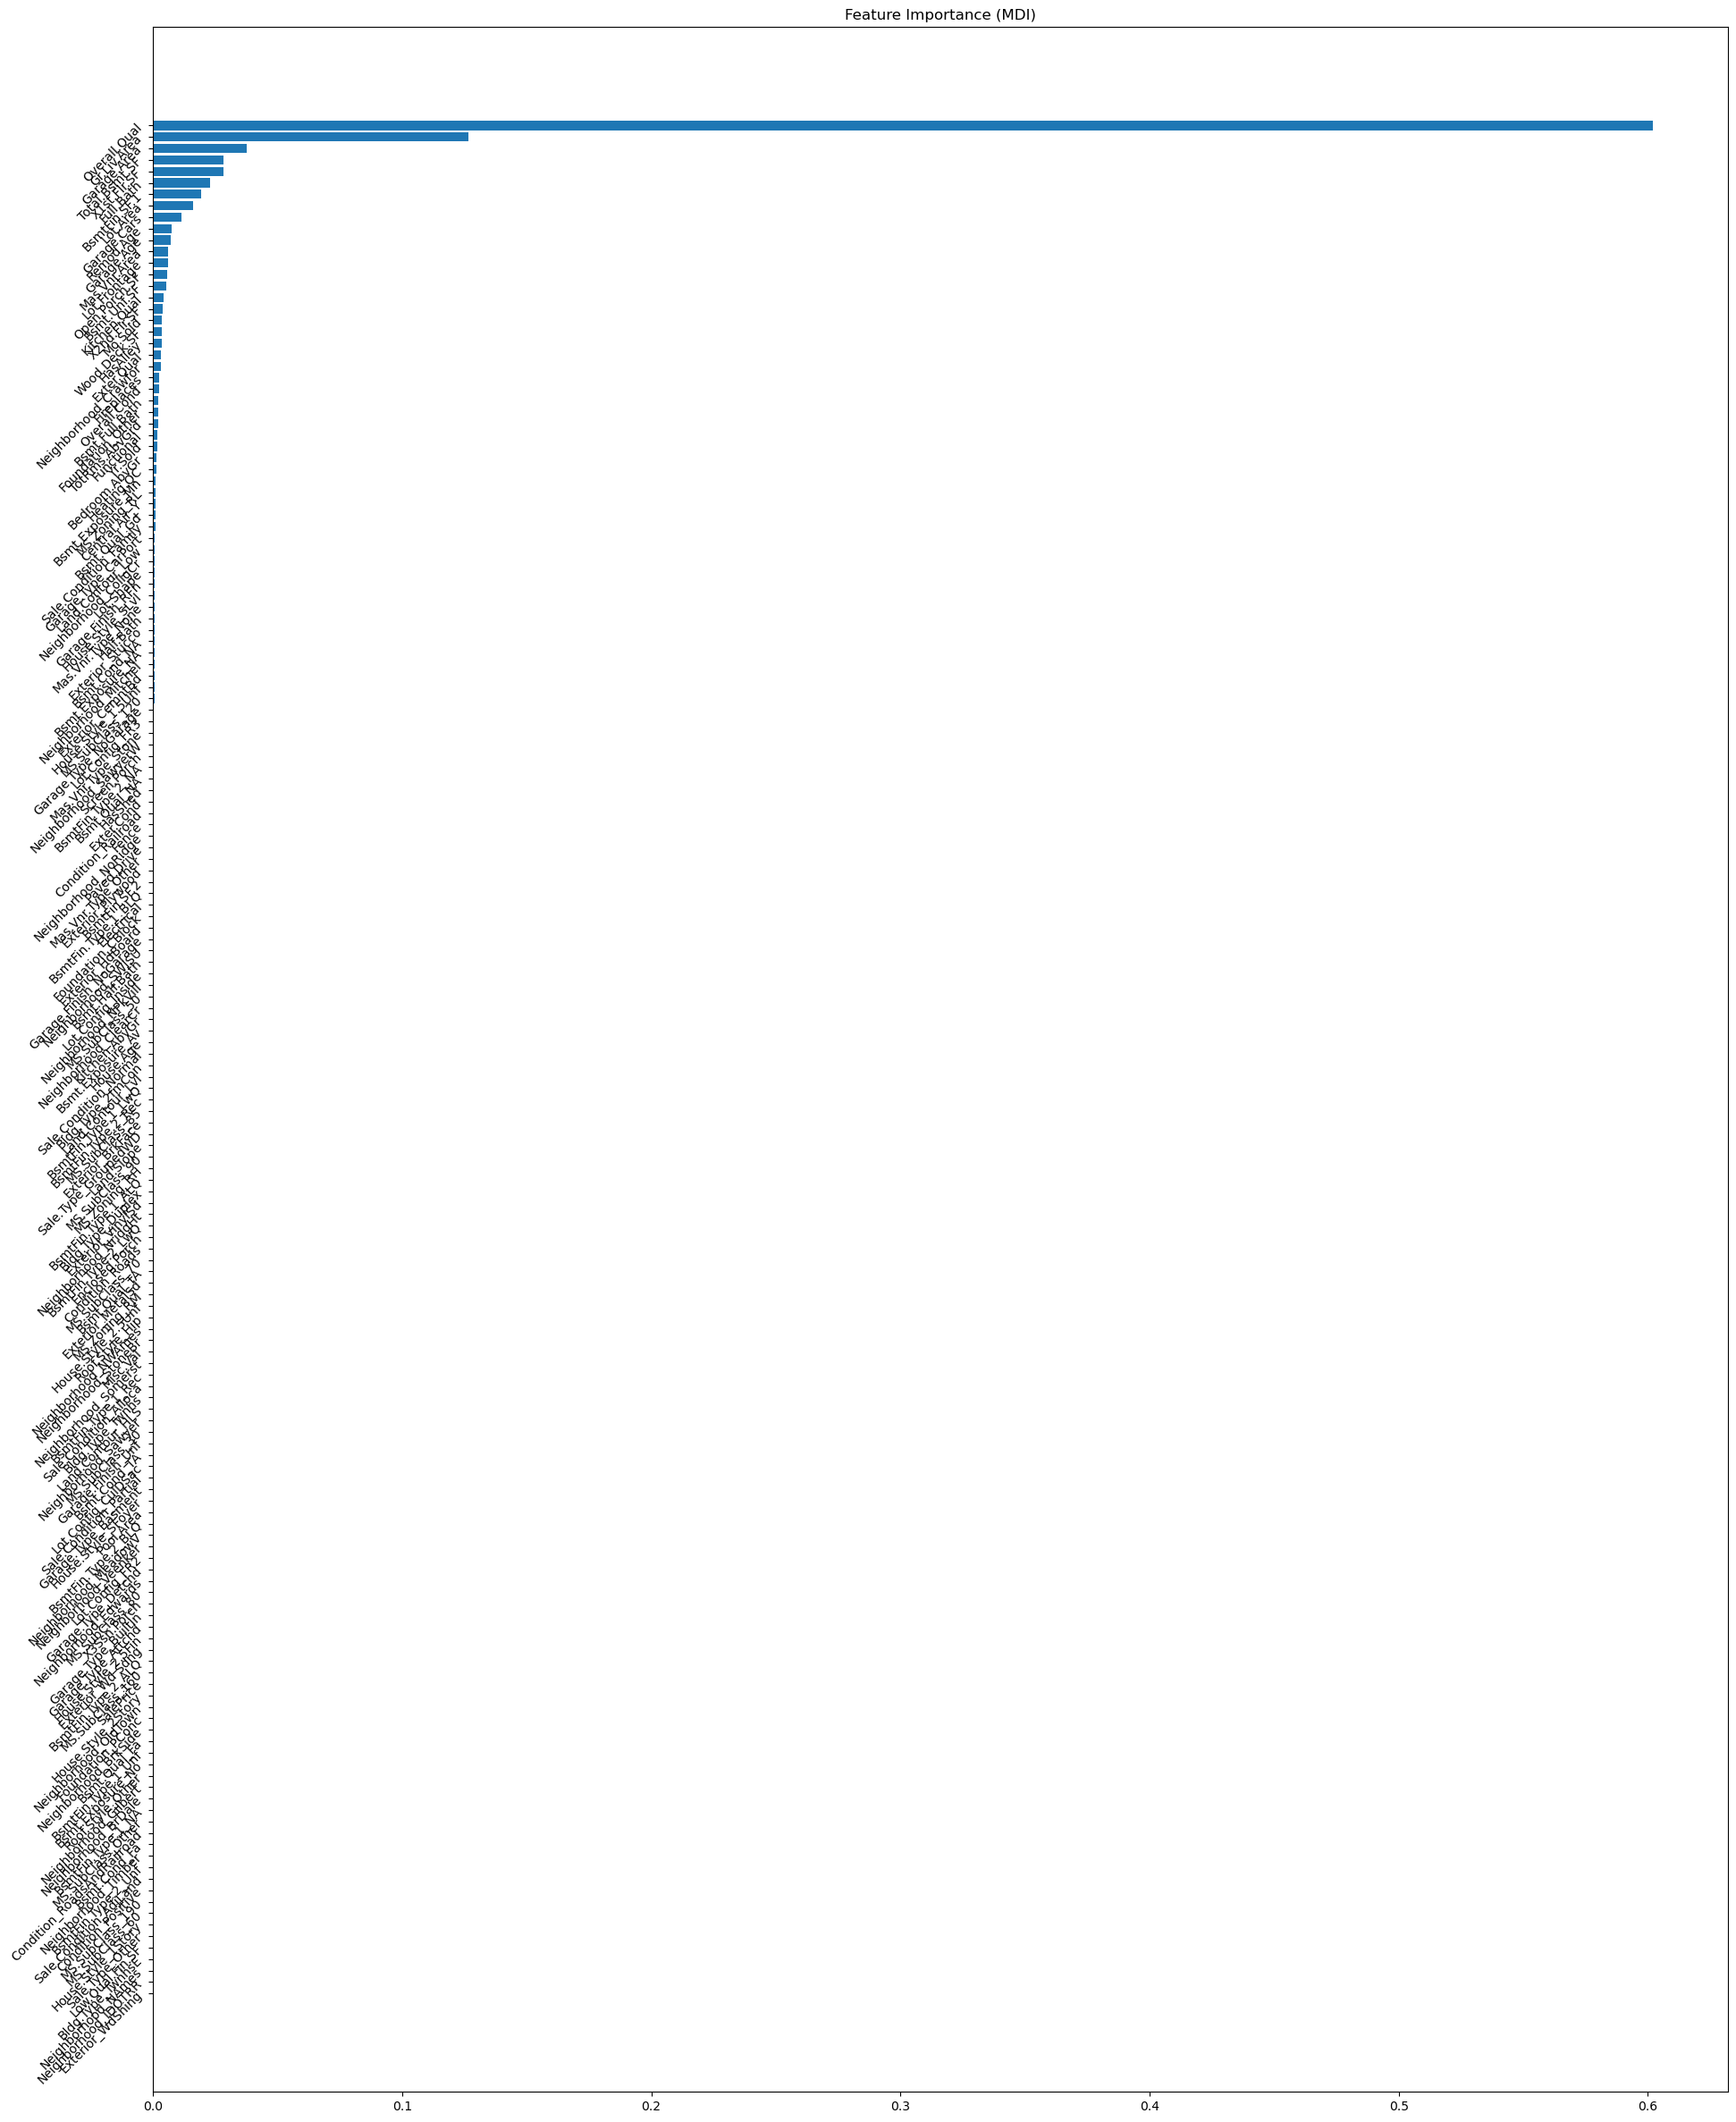

In [ ]:
import matplotlib.pyplot as plt


feature_importance_forest = forest_reg.feature_importances_
sorted_idx = np.argsort(feature_importance_forest)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(50, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_forest[sorted_idx], align="center")
plt.yticks(pos, np.array(model_data.columns)[sorted_idx], rotation=45, ha="right")
plt.title("Feature Importance (MDI)")

Text(0.5, 1.0, 'Feature Importance (MDI)')

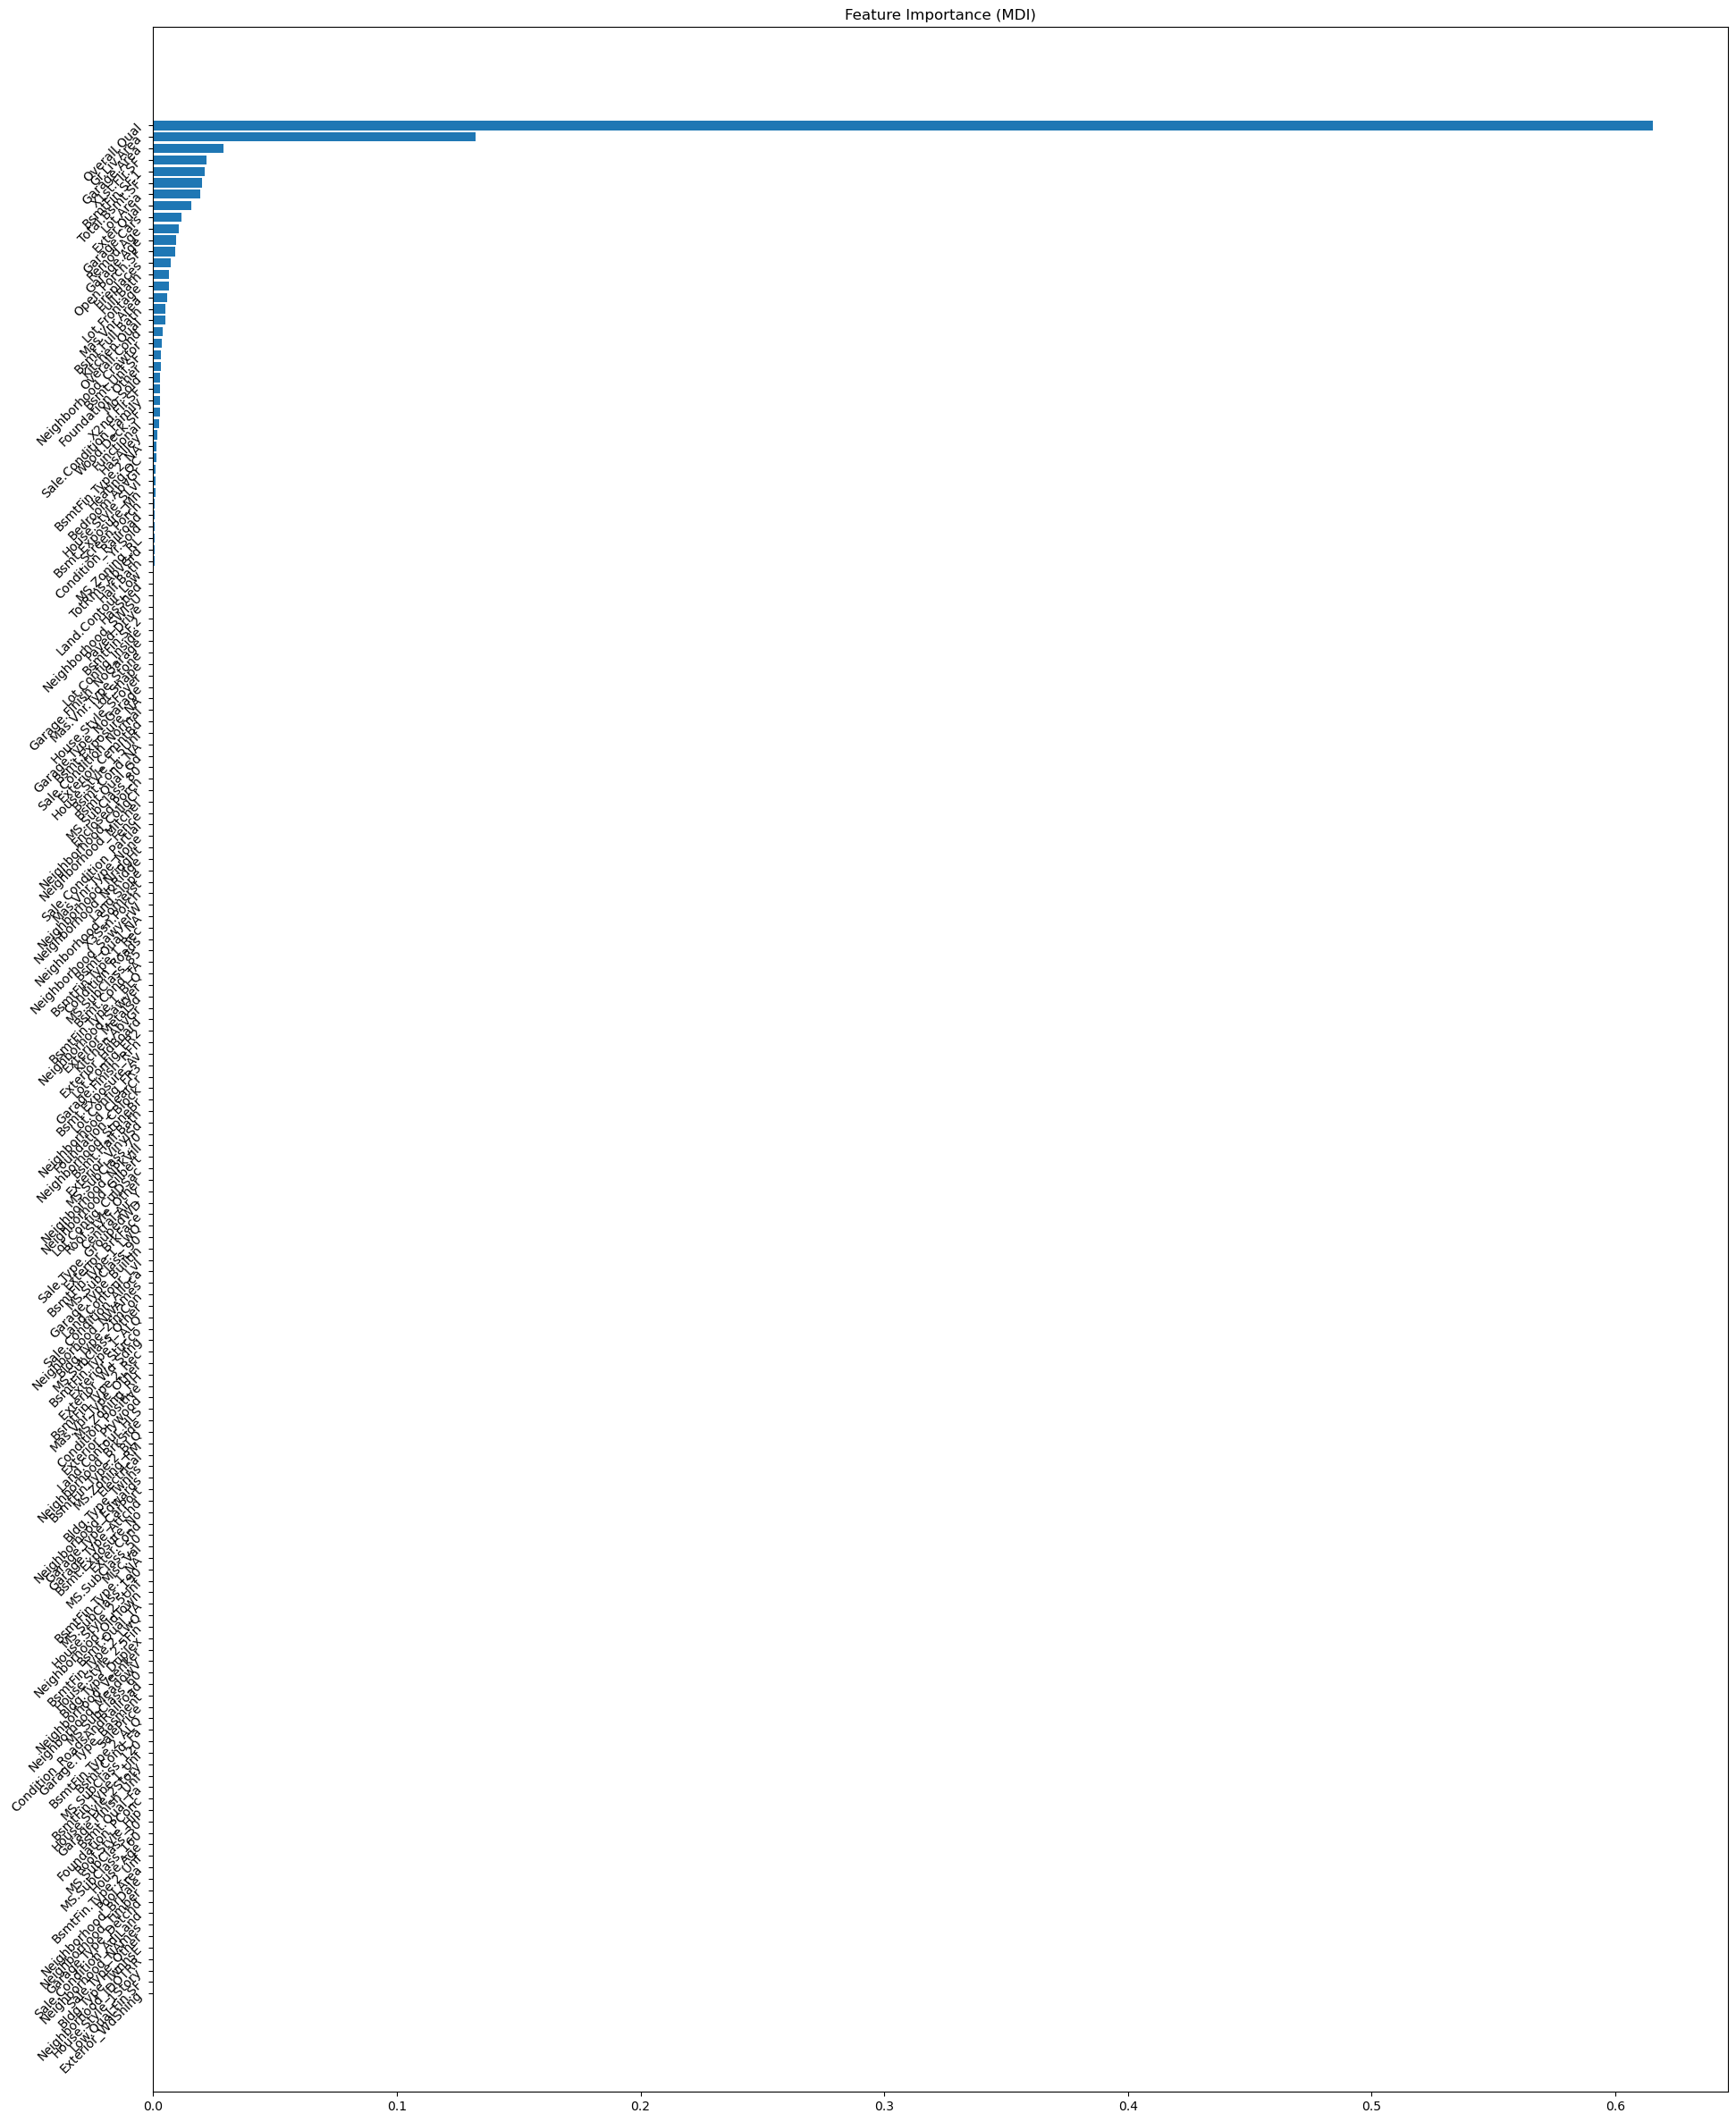

In [ ]:
feature_importance_gbr = gbr_reg.feature_importances_
sorted_idx = np.argsort(feature_importance_gbr)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(50, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance_gbr[sorted_idx], align="center")
plt.yticks(pos, np.array(model_data.columns)[sorted_idx], rotation=45, ha="right")
plt.title("Feature Importance (MDI)")

Text(0.5, 1.0, 'Feature Importance (MDI)')

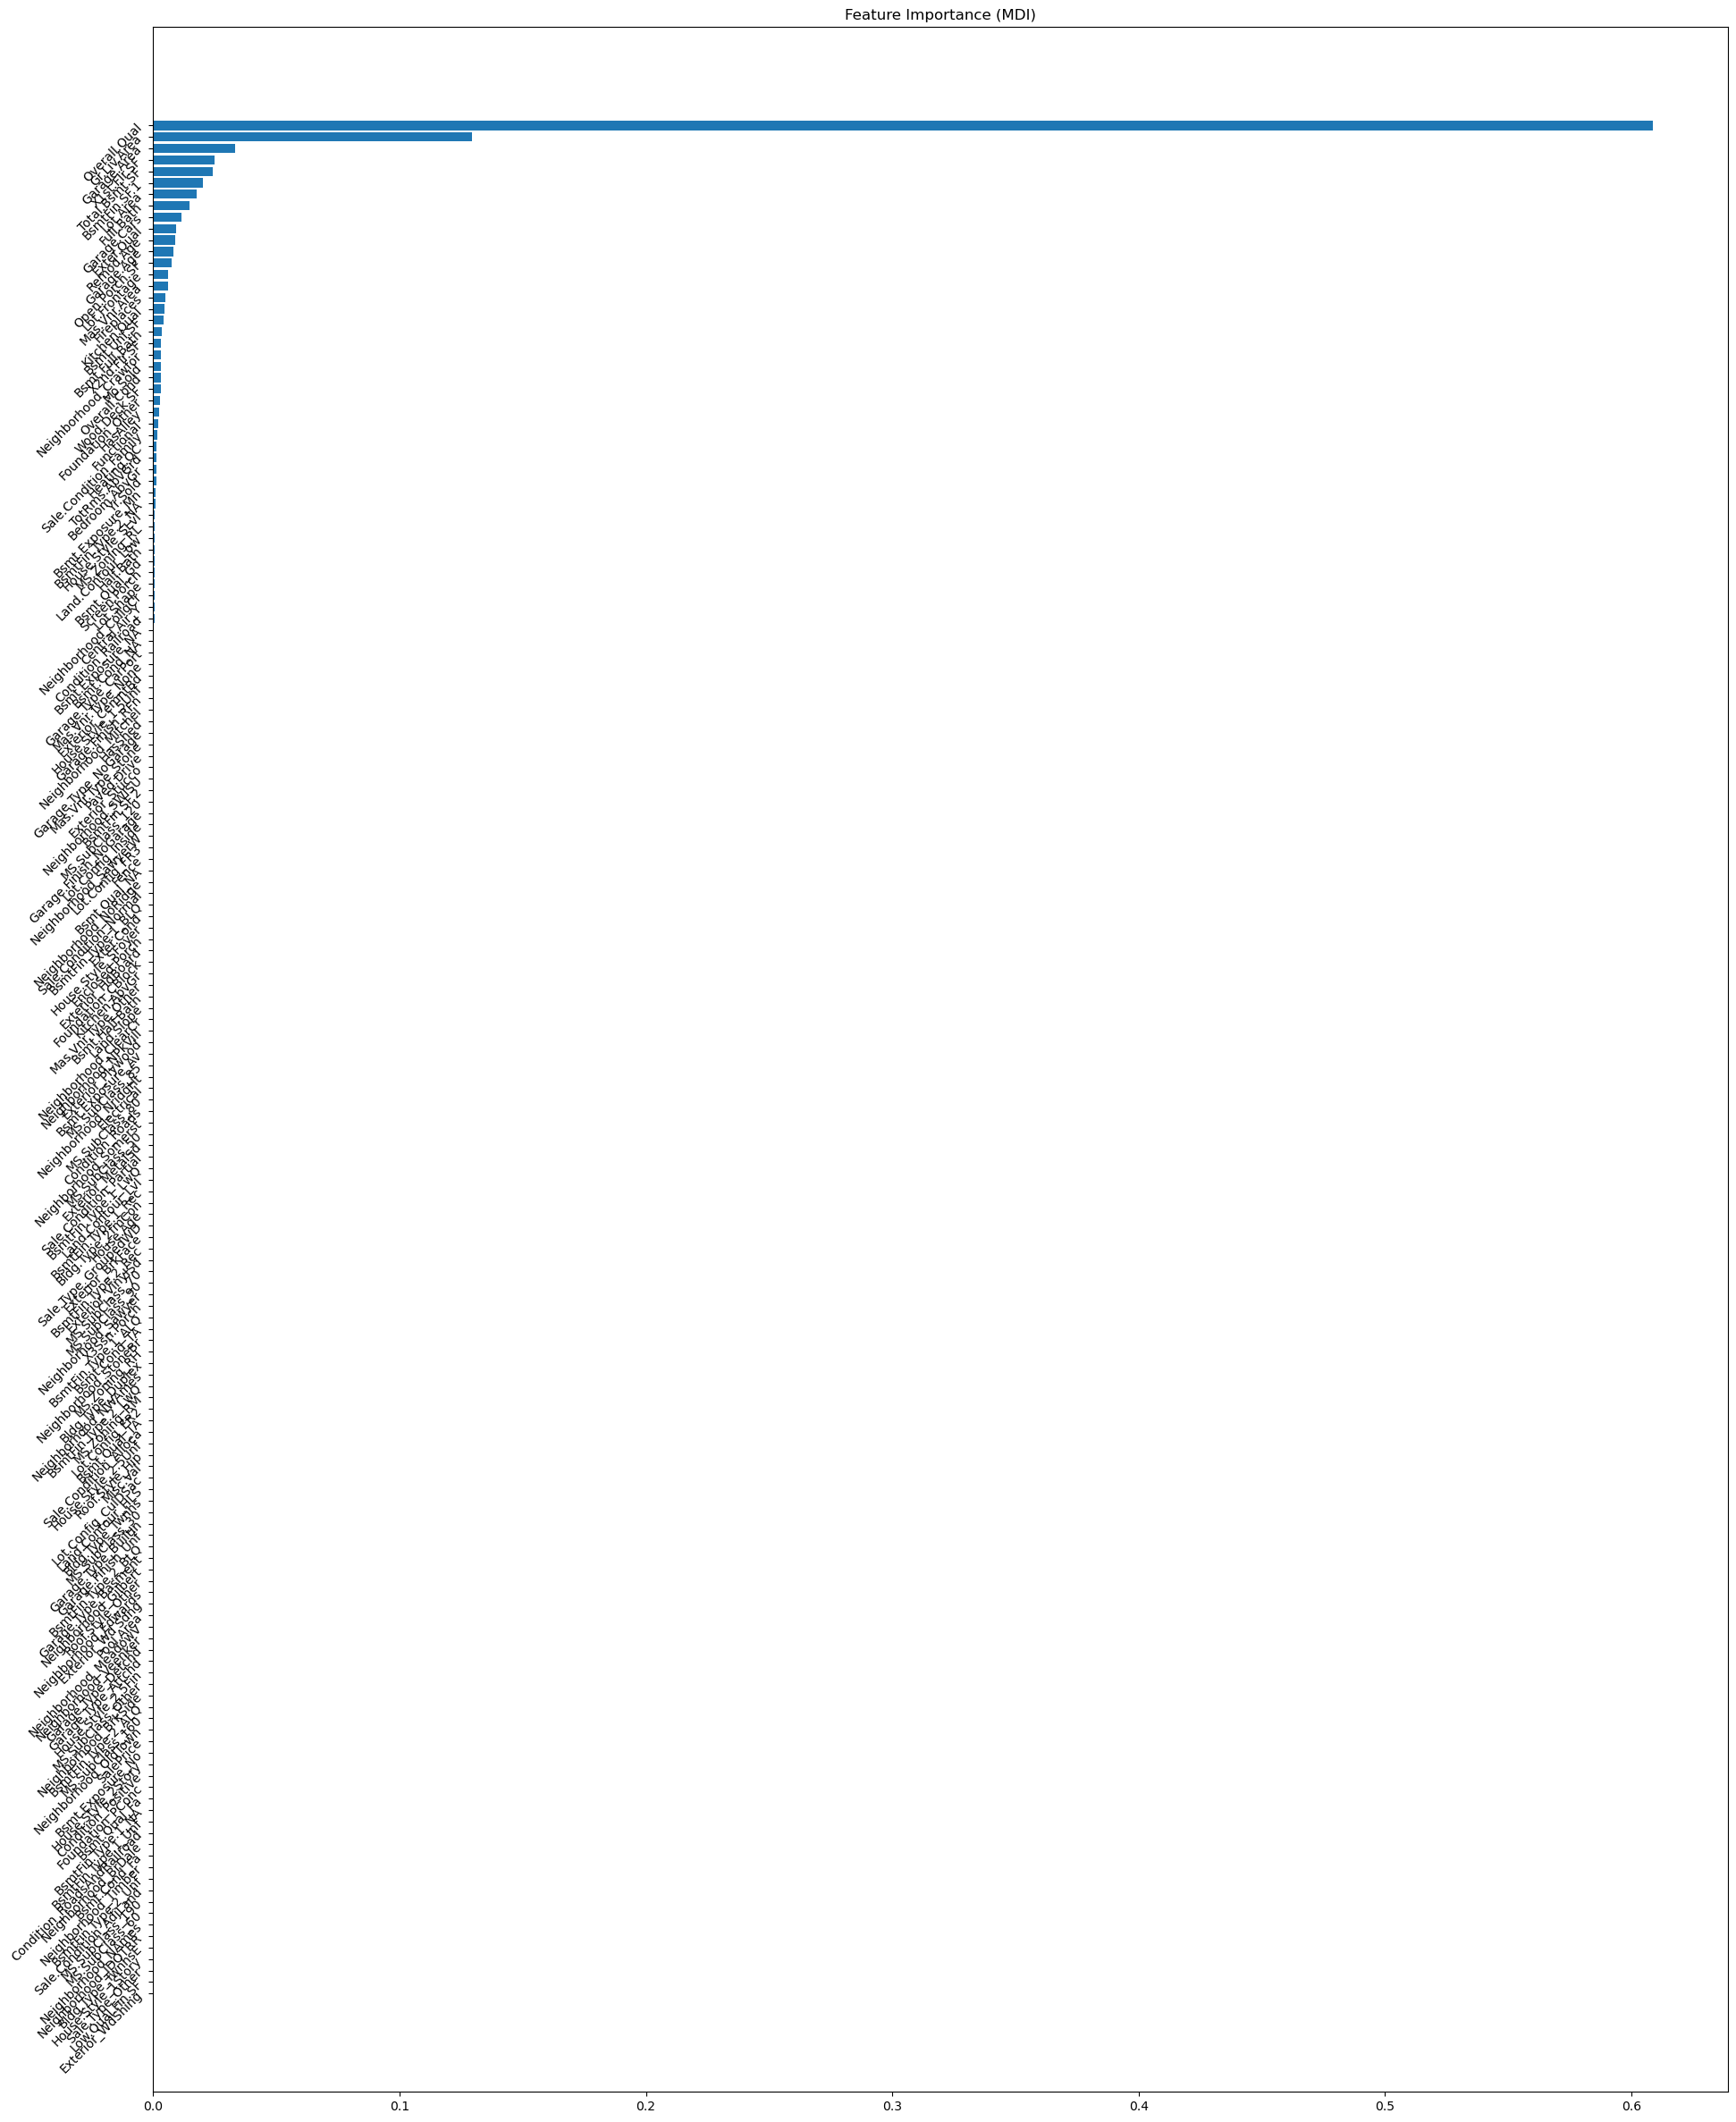

In [ ]:
# Faz a média da importância das features
feature_importance = (feature_importance_forest + feature_importance_gbr) / 2
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(50, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(model_data.columns)[sorted_idx], rotation=45, ha="right")
plt.title("Feature Importance (MDI)")



In [ ]:
# Filtra as 10 features mais importantes
top_15_features = np.array(model_data.columns)[sorted_idx][-15:]
top_15_features


array(['Mas.Vnr.Area', 'Lot.Frontage', 'Open.Porch.SF', 'Garage.Age',
       'Remod.Age', 'Exter.Qual', 'Garage.Cars', 'Full.Bath', 'Lot.Area',
       'BsmtFin.SF.1', 'Total.Bsmt.SF', 'X1st.Flr.SF', 'Garage.Area',
       'Gr.Liv.Area', 'Overall.Qual'], dtype=object)

In [ ]:
# print the 15 most important features and their importance score
print('Feature Importance Score')
print('------------------------')
for i,v in enumerate(feature_importance[sorted_idx][-15:]):
    print(f'Feature: {top_15_features[i]}, Score: {v}')
    

Feature Importance Score
------------------------
Feature: Mas.Vnr.Area, Score: 0.005977793377155722
Feature: Lot.Frontage, Score: 0.0061758173793276154
Feature: Open.Porch.SF, Score: 0.007524729119915199
Feature: Garage.Age, Score: 0.008359431394856988
Feature: Remod.Age, Score: 0.008917830752848011
Feature: Exter.Qual, Score: 0.009509595554168217
Feature: Garage.Cars, Score: 0.01146615608063918
Feature: Full.Bath, Score: 0.014873360127219565
Feature: Lot.Area, Score: 0.01759969608379568
Feature: BsmtFin.SF.1, Score: 0.02027693437430645
Feature: Total.Bsmt.SF, Score: 0.02413970508415119
Feature: X1st.Flr.SF, Score: 0.02501902256957405
Feature: Garage.Area, Score: 0.033206908856659854
Feature: Gr.Liv.Area, Score: 0.1294739398063378
Feature: Overall.Qual, Score: 0.6085847241606643


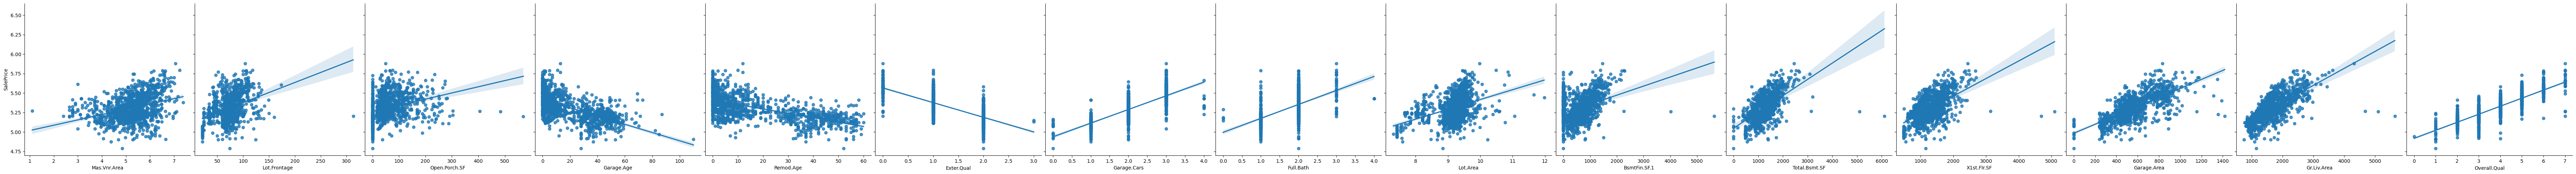

In [ ]:
# faz o gráfico de dispersão das 15 features mais importantes
import seaborn as sns

sns.pairplot(model_data, x_vars=top_15_features, y_vars='SalePrice', height=5, aspect=1, kind='reg')


In [ ]:
# cria um dataframe com as 10 features mais importantes
top_15_features_df = model_data[top_15_features].copy()
top_15_features_df.head()

# cria um dataframe com as 10 features mais importantes e o target
top_15_features_df = model_data[top_15_features].copy()
top_15_features_df['SalePrice'] = model_data['SalePrice'].copy()
top_15_features_df.corr()


,Mas.Vnr.Area,Lot.Frontage,Open.Porch.SF,Garage.Age,Remod.Age,Exter.Qual,Garage.Cars,Full.Bath,Lot.Area,BsmtFin.SF.1,Total.Bsmt.SF,X1st.Flr.SF,Garage.Area,Gr.Liv.Area,Overall.Qual,SalePrice
Mas.Vnr.Area,1.000000,0.183599,0.153903,-0.041972,-0.048738,-0.230972,0.215771,0.103394,0.172711,0.213460,0.260067,0.259270,0.298538,0.392025,0.300281,0.342791
Lot.Frontage,0.183599,1.000000,0.202337,0.020205,-0.004098,-0.132724,0.317295,0.139965,0.638498,0.244557,0.431326,0.474702,0.401961,0.408593,0.234612,0.350433
Open.Porch.SF,0.153903,0.202337,1.000000,-0.204303,-0.231975,-0.236654,0.225352,0.241727,0.237667,0.159732,0.256528,0.257324,0.261365,0.366281,0.266082,0.306571
Garage.Age,-0.041972,0.020205,-0.204303,1.000000,0.847372,0.720825,-0.589690,-0.538570,0.089621,-0.130023,-0.354866,-0.246860,-0.511093,-0.310726,-0.694978,-0.611659
Remod.Age,-0.048738,-0.004098,-0.231975,0.847372,1.000000,0.698310,-0.531764,-0.509303,0.018150,-0.130663,-0.310767,-0.254393,-0.454472,-0.327383,-0.663694,-0.614362
Exter.Qual,-0.230972,-0.132724,-0.236654,0.720825,0.698310,1.000000,-0.554291,-0.442787,-0.095123,-0.247759,-0.491691,-0.412905,-0.541568,-0.438532,-0.775864,-0.721701
Garage.Cars,0.215771,0.317295,0.225352,-0.589690,-0.531764,-0.554291,1.000000,0.499384,0.302063,0.213849,0.450933,0.436740,0.863198,0.540429,0.643923,0.730184
Full.Bath,0.103394,0.139965,0.241727,-0.538570,-0.509303,-0.442787,0.499384,1.000000,0.176127,0.047895,0.307355,0.316831,0.398054,0.585956,0.529336,0.562066
Lot.Area,0.172711,0.638498,0.237667,0.089621,0.018150,-0.095123,0.302063,0.176127,1.000000,0.233018,0.402311,0.481063,0.389631,0.435390,0.195007,0.408279
BsmtFin.SF.1,0.213460,0.244557,0.159732,-0.130023,-0.130663,-0.247759,0.213849,0.047895,0.233018,1.000000,0.524424,0.469394,0.301698,0.244617,0.264098,0.360454


In [ ]:
# feature engineering
# cria uma nova feature com a soma das 15 features mais importantes
top_15_features_df['sum_15_features'] = top_15_features_df[top_15_features].sum(axis=1)
top_15_features_df.head()

,Mas.Vnr.Area,Lot.Frontage,Open.Porch.SF,Garage.Age,Remod.Age,Exter.Qual,Garage.Cars,Full.Bath,Lot.Area,BsmtFin.SF.1,Total.Bsmt.SF,X1st.Flr.SF,Garage.Area,Gr.Liv.Area,Overall.Qual,SalePrice,sum_15_features
0,4.718499,141.0,62.0,50.0,50.0,2,2.0,1.0,10.366278,639.0,1080.0,1656.0,528.0,1656.0,3,5.332438,5885.084777
2,4.682131,81.0,36.0,52.0,52.0,2,1.0,1.0,9.565704,923.0,1329.0,1329.0,312.0,1329.0,3,5.235528,5464.247836
5,2.995732,78.0,36.0,12.0,12.0,2,2.0,2.0,9.208138,602.0,926.0,926.0,470.0,1604.0,3,5.291147,4687.203870
15,6.401917,47.0,36.0,7.0,7.0,0,3.0,3.0,10.887512,1416.0,1650.0,1690.0,841.0,3279.0,5,5.730782,9001.289429
17,5.857933,88.0,0.0,0.0,0.0,1,3.0,1.0,9.340842,1445.0,1856.0,1856.0,834.0,1856.0,6,5.595972,7961.198775


In [ ]:
# correlação da nova feature com o target
top_15_features_df.corr()


,Mas.Vnr.Area,Lot.Frontage,Open.Porch.SF,Garage.Age,Remod.Age,Exter.Qual,Garage.Cars,Full.Bath,Lot.Area,BsmtFin.SF.1,Total.Bsmt.SF,X1st.Flr.SF,Garage.Area,Gr.Liv.Area,Overall.Qual,SalePrice,sum_15_features
Mas.Vnr.Area,1.000000,0.183599,0.153903,-0.041972,-0.048738,-0.230972,0.215771,0.103394,0.172711,0.213460,0.260067,0.259270,0.298538,0.392025,0.300281,0.342791,0.370149
Lot.Frontage,0.183599,1.000000,0.202337,0.020205,-0.004098,-0.132724,0.317295,0.139965,0.638498,0.244557,0.431326,0.474702,0.401961,0.408593,0.234612,0.350433,0.512786
Open.Porch.SF,0.153903,0.202337,1.000000,-0.204303,-0.231975,-0.236654,0.225352,0.241727,0.237667,0.159732,0.256528,0.257324,0.261365,0.366281,0.266082,0.306571,0.368067
Garage.Age,-0.041972,0.020205,-0.204303,1.000000,0.847372,0.720825,-0.589690,-0.538570,0.089621,-0.130023,-0.354866,-0.246860,-0.511093,-0.310726,-0.694978,-0.611659,-0.347598
Remod.Age,-0.048738,-0.004098,-0.231975,0.847372,1.000000,0.698310,-0.531764,-0.509303,0.018150,-0.130663,-0.310767,-0.254393,-0.454472,-0.327383,-0.663694,-0.614362,-0.337201
Exter.Qual,-0.230972,-0.132724,-0.236654,0.720825,0.698310,1.000000,-0.554291,-0.442787,-0.095123,-0.247759,-0.491691,-0.412905,-0.541568,-0.438532,-0.775864,-0.721701,-0.515300
Garage.Cars,0.215771,0.317295,0.225352,-0.589690,-0.531764,-0.554291,1.000000,0.499384,0.302063,0.213849,0.450933,0.436740,0.863198,0.540429,0.643923,0.730184,0.576068
Full.Bath,0.103394,0.139965,0.241727,-0.538570,-0.509303,-0.442787,0.499384,1.000000,0.176127,0.047895,0.307355,0.316831,0.398054,0.585956,0.529336,0.562066,0.412141
Lot.Area,0.172711,0.638498,0.237667,0.089621,0.018150,-0.095123,0.302063,0.176127,1.000000,0.233018,0.402311,0.481063,0.389631,0.435390,0.195007,0.408279,0.507275
BsmtFin.SF.1,0.213460,0.244557,0.159732,-0.130023,-0.130663,-0.247759,0.213849,0.047895,0.233018,1.000000,0.524424,0.469394,0.301698,0.244617,0.264098,0.360454,0.690099


# Teste das alterações

In [ ]:
# train test split
X = top_15_features_df.drop(columns=['SalePrice']).copy()
y = top_15_features_df['SalePrice'].copy()

Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_SEED,
)

In [ ]:
# testa o modelo de stacking regressor só com as 15 features mais importantes e a nova feature criada

stack_reg_scores = cross_val_score(stack_reg, Xtrain2, ytrain2,
                                      scoring="neg_mean_squared_error", cv=8, n_jobs=-1)    
stack_reg_rmse_scores = np.sqrt(-stack_reg_scores)

print(stack_reg_rmse_scores)
print(stack_reg_rmse_scores.mean())

[0.05519784 0.04703804 0.06388941 0.04542094 0.04943929 0.05278455
 0.05091351 0.05963061]
0.053039273836476004


In [ ]:
# converte o resultado para o valor original
mean_scores = stack_reg_rmse_scores.mean()
mean_scores = (10**mean_scores - 1) * 100
print(mean_scores)

12.989808826283245


# Analisando Correlações + Features
Inicialmente utilizamos o RandomForest e DecisionTree buscar entender como um modelo complexo interage com nosso banco de dados. Com os benchmarks feitos, buscamos outras formas e modelos que pudessemos implementar, que reduzissem a porcentagem de erro. Com isso chegamos no StakingRegressor em que utilizamos três regressores em formato de stack.

```python
estimators = [
    ('rf', forest_reg),
    ('ls', lasso_reg),
    ('gb', gbr_reg)    
]
```

Após plotar o gráfico das importâncias médias das features, percebemos que apenas 10 features estavam ditando o resultado do modelo. Para solucionar isso, agora daremos inicio a mais uma rodada, adicional a realizada no documento <b>02_analysis_and_preprocessing</b> buscando correlações entre duas ou mais features que poderiam ser múltiplicadas.

## Quais são as 10 Features que ditam o modelo?

1. Lot.Area
2. Exter.Qual
3. BsmtFin.SF.2
4. Overall.Cond
5. Heating.QC
6. Land.Slope
7. Mas.Vn.Area
8. Bsmt.Unf.SF
9. Overall.Qual
10. Exter.Cond



In [ ]:
# Testa o modelo de stacking regressor com o conjunto de teste
stack_reg.fit(Xtrain, ytrain)
y_pred = stack_reg.predict(Xtest)
RMSE = np.sqrt(mean_squared_error(y_pred, ytest))

print(f'Stacking Regressor:')
print(f'RMSE: {RMSE}')


c:\Users\rodri\anaconda3\envs\mirror\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.328e-02, tolerance: 1.843e-03
  model = cd_fast.enet_coordinate_descent(


Stacking Regressor:
RMSE: 0.06013212598371809



In [ ]:
# converte o resultado para o valor original
RMSE = (10**RMSE - 1) * 100
print(f'RMSE: {RMSE}')

RMSE: 14.850297892933684
